### Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest,chi2
from tensorflow.keras import layers, models

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject


### Defining Reading ,Splitting Data and Machine Learning Model Functions

#### Getting Data From CSV and Scale on Standartscaler

In [3]:
def read_and_split_data():
    data=pd.read_csv("data_extended_3s_final.csv")
    df=data.copy()
    # y=df["label"]
    # X=df.drop(["label","filename"],axis=1).astype("float64")
    y=df["genre_number"]
    X=df.drop(["label","genre_number"],axis=1).astype("float64")
    cols = X.columns
    scaler = StandardScaler()
    np_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(np_scaled, columns = cols)
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
    return X_train,X_test,y_train,y_test

#### Machine learning Models and Pipelines Function

In [8]:
def ml_model(params,model):
    data=pd.read_csv("data_extended_3s_final.csv")
    df=data.copy()
    y=df["label"]
    X=df.drop(["label","genre_number"],axis=1).astype("float64")
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)


    model_pip = Pipeline([
        ('scale', MinMaxScaler()),
        ('feature_selection', SelectKBest(chi2,k=18)),
        ('pca',PCA(n_components=0.95)),
        ('cls', model)
    ])

    model_cv = GridSearchCV(model_pip, params,n_jobs=-1, cv=10,verbose=2)
    model_cv.fit(X_train, y_train)
    y_pred = model_cv.predict(X_test)
    print("best score on validation set (accuracy) = {:.4f}".format(model_cv.best_score_))
    print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, y_pred)))
    return X_train,X_test,y_test,y_pred

#### CNN Training Model

In [50]:
def train_model(model,epochs,optimizer,X_train,X_test,y_train,y_test):
    batch_size =128
    model.compile(optimizer=optimizer,
                    loss="sparse_categorical_crossentropy",
                    metrics="accuracy")
    return model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=batch_size)

#### Visualize Confusion Matrix and Plot CNN Validation

In [6]:
def conf_matrix(y_test,y_pred,model_name):
    labels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
    confusion_matr = confusion_matrix(y_test, y_pred,normalize="true");

    plt.figure(figsize = (16, 9));
    sns.heatmap(confusion_matr, cmap="Blues", annot=True,
                xticklabels = labels,
                yticklabels=labels);
    plt.title("Confusion Matrix of {}".format(model_name));
    plt.ylabel("true label");
    plt.xlabel("predict label");
    plt.savefig("conf_matrix_{}".format(model_name));


def plot_validate(history):
    print("Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.title("CNN Validation Accuracy")
    plt.savefig("cnn_validation_accuracy");

### KNN

In [9]:
knn_params = {"cls__metric":["euclidean","manhattan","minkowski"],
                "cls__n_neighbors": np.arange(1,50)}
X_train_knn,X_test_knn,y_test_knn,y_pred_knn=ml_model(knn_params,KNeighborsClassifier())


Fitting 10 folds for each of 147 candidates, totalling 1470 fits
best score on validation set (accuracy) = 0.5755
best score on test set (accuracy) = 0.5892


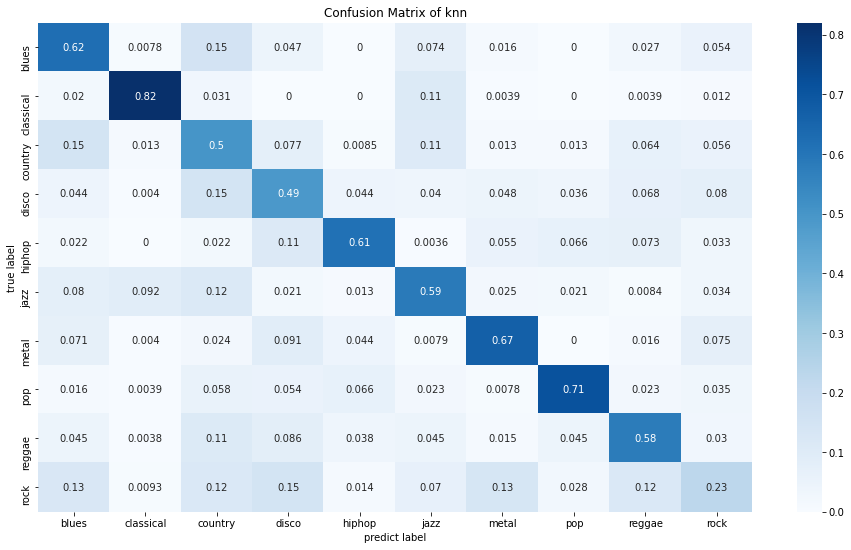

In [8]:
conf_matrix(y_test_knn,y_pred_knn,"knn");

### SVM

In [126]:
svc_params = {'cls__C': [0.0001, 0.001, 0.1, 1, 5, 10 ,50 ,100],
                'cls__gamma': [0.0001, 0.001, 0.1, 1, 5, 10 ,50 ,100],
                'cls__kernel': ['rbf']}
X_train_svc,X_test_svc,y_test_svc,y_pred_svc=ml_model(svc_params,SVC())

Fitting 10 folds for each of 64 candidates, totalling 640 fits
best score on validation set (accuracy) = 0.6087
best score on test set (accuracy) = 0.6156


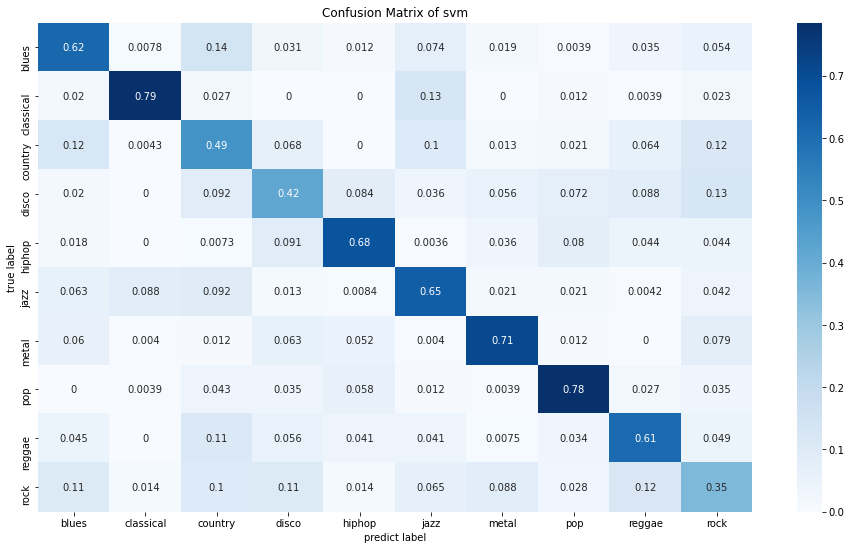

In [145]:
conf_matrix(y_test_svc,y_pred_svc,"svm")

### CNN

In [51]:
X_train_cnn,X_test_cnn,y_train_cnn,y_test_cnn=read_and_split_data()
model=models.Sequential([
    layers.Dense(64,activation="relu",input_shape=(X_train_cnn.shape[1],)),
    layers.Dropout(0.2),

    layers.Dense(128,activation="relu"),
    layers.Dropout(0.2),

    layers.Dense(128,activation="relu"),
    layers.Dropout(0.2),

    layers.Dense(128,activation="relu"),
    layers.Dropout(0.2),

    layers.Dense(10,activation="softmax"),
])
model_history=train_model(model=model,epochs=125,optimizer='adam',X_train=X_train_cnn,X_test=X_test_cnn,y_train=y_train_cnn,y_test=y_test_cnn)

test_loss,test_acc=model.evaluate(X_test_cnn,y_test_cnn,batch_size=128)

Epoch 1/125
59/59 [==============================] - 1s 7ms/step - loss: 1.9046 - accuracy: 0.3171 - val_loss: 1.4310 - val_accuracy: 0.5164
Epoch 2/125
59/59 [==============================] - 0s 5ms/step - loss: 1.4706 - accuracy: 0.4795 - val_loss: 1.1498 - val_accuracy: 0.6016
Epoch 3/125
59/59 [==============================] - 0s 5ms/step - loss: 1.2849 - accuracy: 0.5495 - val_loss: 1.0240 - val_accuracy: 0.6536
Epoch 4/125
59/59 [==============================] - 0s 6ms/step - loss: 1.1834 - accuracy: 0.5823 - val_loss: 0.9285 - val_accuracy: 0.6840
Epoch 5/125
59/59 [==============================] - 0s 4ms/step - loss: 1.0951 - accuracy: 0.6143 - val_loss: 0.8895 - val_accuracy: 0.6968
Epoch 6/125
59/59 [==============================] - 0s 4ms/step - loss: 1.0475 - accuracy: 0.6328 - val_loss: 0.8430 - val_accuracy: 0.7104
Epoch 7/125
59/59 [==============================] - 0s 4ms/step - loss: 0.9952 - accuracy: 0.6500 - val_loss: 0.8150 - val_accuracy: 0.7200
Epoch 8/125
5

In [52]:
print("The test loss is: ",test_loss)
print("The best test accuracy is :",test_acc)

The test loss is:  0.4160667955875397
The best test accuracy is : 0.8583999872207642


Validation Accuracy 0.8604000210762024


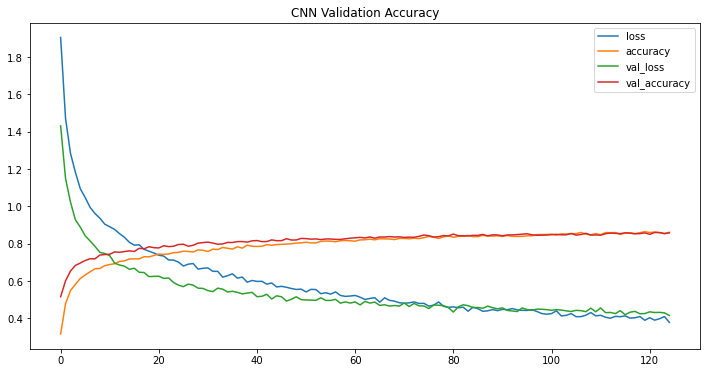

In [53]:
plot_validate(model_history)

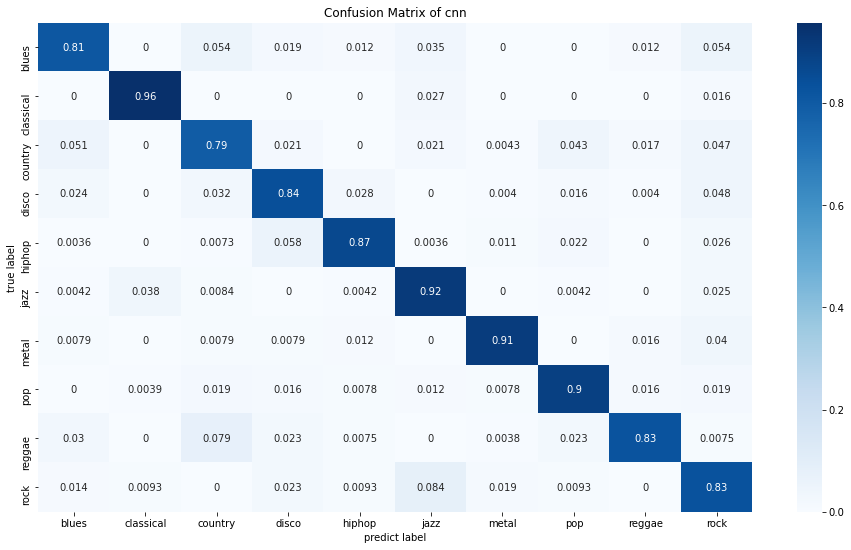

In [36]:
y_pred_cnn = np.argmax(model.predict(X_test_cnn), axis = 1)
conf_matrix(y_test_cnn,y_pred_cnn,"cnn")